# Tuning Model

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load in Data
x_file = 'synthetic_data/batch_1/x_gen_syn_n3_p10_corr0.5_snr5_seed2022_0.csv'
y_file = 'synthetic_data/batch_1/y_gen_syn_n3_p10_corr0.5_snr5_seed2022_0.csv'
x = np.loadtxt(x_file, delimiter=",")
y = np.loadtxt(y_file, delimiter=",")
l0 = 0.01
l2 = 0

# Tuning Tree Parameters

In [5]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model to estimate coefficients (betas)
linear_model = LinearRegression()
linear_model.fit(x, y)

# Calculate the maximum absolute coefficient value
max_abs_beta = np.max(np.abs(linear_model.coef_))

# Calculate the optimal M value as 1.5 times the maximum absolute coefficient value
optimal_M = 1.5 * max_abs_beta

print(f"Optimal M: {optimal_M}")

Optimal M: 1.342228603310831


# Retro Branching

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

### Rough Visualization of Tree Structure

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=2., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5, pos = None, parent = None, parsed = []):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
            
    if len(children) != 0:
        dx = width / len(children) 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    
    return pos

def visualize_tree(root):
    if not root:
        return

    tree_graph = nx.DiGraph()

    def add_nodes_edges(node):
        if node.left:
            tree_graph.add_edge(node.node_key, node.left.node_key)
            add_nodes_edges(node.left)
        if node.right:
            tree_graph.add_edge(node.node_key, node.right.node_key)
            add_nodes_edges(node.right)

    add_nodes_edges(root)

    pos = hierarchy_pos(tree_graph, root.node_key)
    nx.draw(tree_graph, pos=pos, with_labels=True, node_size=100, node_color="skyblue", font_size=6, font_weight='bold')
    plt.title("Binary Tree Visualization")
    plt.show()

In [11]:
import Tree
# Solve using Branch and Bound
p = Tree.Problem(x,y,l0,l2, m = 1.3)
tree = Tree.tree(p)
i, reward, nnz, og = tree.branch_and_bound()

def count_nodes(node):
    """Count the number of nodes in the tree."""
    if not node:
        return 0
    return 1 + count_nodes(node.left) + count_nodes(node.right)

print(f'Number of iterations: {i}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {og}')

Number of iterations: 113
Number of Non-Zero: 4
Optimality Gap: 0.0


In [4]:
from Model import Agent

#initialize agent
agent = Agent()

# Solve Using RL Agent
i, reward, nnz, og = agent.RL_solve(tree)

print(f'Number of iterations: {i}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {og}')
print(f'Number of Items in Memory: {len(agent.memory.memory)}')
print("-----------------------------------------")
print(f'Episodes Played: {agent.episodes_played}')
print(f'Epsilon: {round(agent.epsilon,4)}')

Number of iterations: 99
Number of Non-Zero: 2
Optimality Gap: -0.06192286067550717
Number of Items in Memory: 198
-----------------------------------------
Episodes Played: 1
Epsilon: 0.99


Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Episode 0 - Total Reward: -101, Iterations: 102
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Episode 10 - Total Reward: -15, Iterations: 16
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Episode 20 - Total Reward: -4, Iterations: 5
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Maximum KKT check iterations reached, increase kkt_max_itr to avoid this warning
Maximum KKT check iterations reached, increase kkt

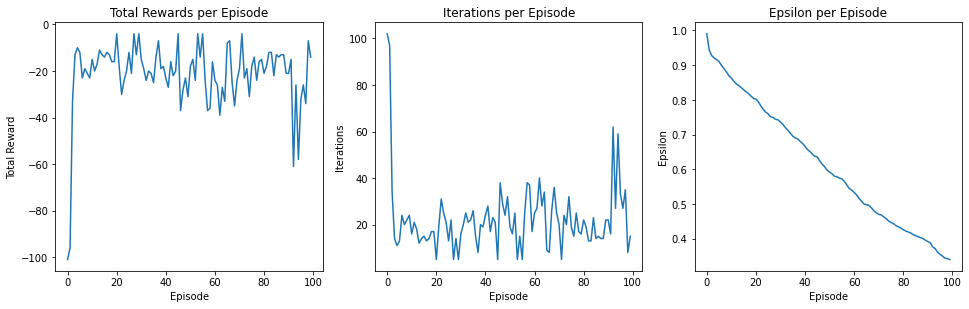

In [8]:
import matplotlib.pyplot as plt

# Initialize New Agent
agent = Agent()

total_rewards = []
iterations_per_episode = []
epsilons = []

# Play through 100 episodes
for episode in range(100):
    iters, tot_reward, test_tree = agent.RL_solve(agent, x, y, l0, l2, 1.3)
    total_rewards.append(tot_reward)
    iterations_per_episode.append(iters)
    epsilons.append(agent.epsilon)
    if episode % 10 == 0:
        print(f"Episode {episode} - Total Reward: {tot_reward}, Iterations: {iters}")

# Plotting the results
plt.figure(figsize=(18, 8))

plt.subplot(2, 4, 1)
plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 4, 2)
plt.plot(iterations_per_episode)
plt.title('Iterations per Episode')
plt.xlabel('Episode')
plt.ylabel('Iterations')

plt.subplot(2, 4, 3)
plt.plot(epsilons)
plt.title('Epsilon per Episode')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

# Tuning Model

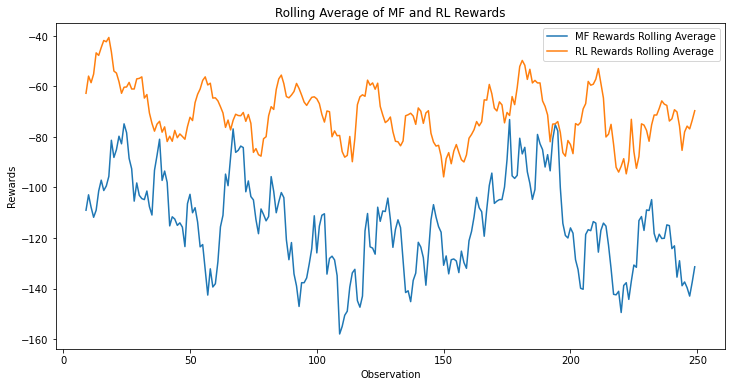

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('synthetic_data/results/results_p10.csv')

# Calculate rolling average for MF_rewards and RL_rewards
window_size = 10 # You can adjust the window size as needed
data['MF_rewards_rolling'] = data['MF_rewards'].rolling(window=window_size).mean()
data['RL_rewards_rolling'] = data['RL_rewards'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['MF_rewards_rolling'], label='MF Rewards Rolling Average')
plt.plot(data['RL_rewards_rolling'], label='RL Rewards Rolling Average')
plt.title('Rolling Average of MF and RL Rewards')
plt.xlabel('Observation')
plt.ylabel('Rewards')
plt.legend()
plt.show()